# MIMIC - data exploration

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
from collections import defaultdict
sys.path.append('/home/datasets/MIMIC/code')
from numpy import mean, std
from __future__ import print_function

Declare all used patuh variables

In [2]:
mimic_file = '/home/datasets/MIMIC/MIMIC2/MIMIC_PREPROCESSED'
ICD9_DESCRIPTIONS = '/home/datasets/MIMIC/ICD9/ICD9_descriptions'
CODE_ROUTE = '/home/datasets/MIMIC/MIMIC2/all_codes_with_route'
mimic2_file = '/home/datasets/MIMIC/MIMIC2/MIMIC_PREPROCESSED'
mimic3_file = '/home/datasets/MIMIC/MIMIC3/MIMIC_PREPROCESSED'

Function to preety print statistics

In [19]:
def pp_stats(stats):
    out_str = ''
    for f in [sum, mean, max, min, std]:
        out_str += f.__name__+' '+str(f(stats))+'\n'
    return out_str

Load MIMIC dataset:  each document is represented by a list of ICD9 codes and a list of tokens.
We create one list for tokens and one for codes.

In [13]:
from tal import mimic_doc_yielder

all_codes_per_doc = []
all_tokens_per_doc = []
num_of_docs = 0
for codes, tokens in mimic_doc_yielder(mimic_file):
    all_codes_per_doc.append(codes)
    all_tokens_per_doc.append(tokens)
    num_of_docs += 1

Load ICD9 codes - map each code to its verbal description.

In [14]:
code_to_name = {}

for line in open(ICD9_DESCRIPTIONS):
    line = line.strip().split('\t')
    code_to_name[line[0]] = line[1]
    
print('First code in ICD9: '+code_to_name.keys()[0])

First code in ICD9: 524.70


ICD9 codes are organized in a hiearchy - load the hierarchy that maps each code to its depth in the hierarchy.

In [15]:
code_to_route_len = {}

for line in open(CODE_ROUTE):
    line = line.strip().split()
    code_to_route_len[line[0]] = len(line[1].split(','))

In [16]:
print('Num of docs: ' + str(num_of_docs))

Num of docs: 22815


Gather descriptive statistics on the text of documents:

In [17]:
stat = map(len, all_tokens_per_doc)
print('Tokens stats (total, avg, max, min, std)', sum(stat), mean(stat), max(stat), min(stat), std(stat))

Tokens stats (total, avg, max, min, std) 33713452 1477.68801227 8130 59 859.512012504


Gather descriptive statistics on codes (number of codes per document):

In [21]:
stat = map(len, all_codes_per_doc)
print('codes stats:\n'+pp_stats(stat))

codes stats:
sum 215826
mean 9.45982905983
max 39
min 1
std 4.70107971489



Number of documents associated to each code:

In [22]:
code_to_num_of_docs = defaultdict(int)
for doc in all_codes_per_doc:
    for code in doc:
        code_to_num_of_docs[code] += 1
stat = code_to_num_of_docs.values()
print('docs per label\n'+pp_stats(stat))

docs per label
sum 215826
mean 42.8992248062
max 9544
min 1
std 253.05458329



Draw histogram of number of documents associated to each code.


We only show labels that are associated to more than 50 documents.

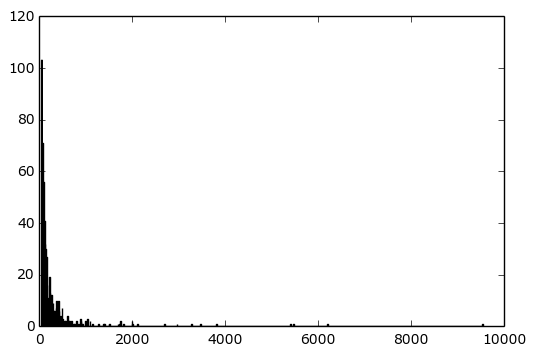

In [23]:
docs_per_label = code_to_num_of_docs.values()
docs_per_label = filter(lambda x: x > 49, docs_per_label)
docs_per_label.sort(reverse=True)
plt.hist(docs_per_label, bins=len(docs_per_label))
plt.show()

Number of codes that are associated with more than 50 documents (out of about 7,000 codes in ICD9):

In [25]:
print(len(docs_per_label))

598


Print the 50 most frequent codes:

In [27]:
labels_count = defaultdict(int)
for doc_labels in all_codes_per_doc:
    for label in doc_labels:
        labels_count[label] += 1
count_to_label = map(lambda label: (labels_count[label], label), labels_count.keys())
count_to_label.sort(reverse=True)

top_50 = map(lambda x: x[1], count_to_label[:50])
pprint = map(lambda x: '\t'.join([x, str(code_to_route_len[x]), code_to_name[x][:80]]), top_50)
print('50 top labels\n'+'\n'.join(pprint))

50 top labels
401.9	6	Unspecified essential hypertension
414.01	7	Coronary atherosclerosis of native coronary artery
427.31	7	Atrial fibrillation
428.0	6	Congestive heart failure, unspecified
250.00	7	type II diabetes mellitus [non-insulin dependent type] [NIDDM type] [adult-onset
272.0	6	Pure hypercholesterolemia
584.9	6	Acute renal failure, unspecified
518.81	7	Acute respiratory failure
599.0	6	Urinary tract infection, site not specified
530.81	7	Esophageal reflux
486	5	Pneumonia, organism unspecified
272.4	6	Other and unspecified hyperlipidemia
285.9	5	Anemia, unspecified
496	5	Chronic airway obstruction, not elsewhere classified
410.71	7	Acute myocardial infarction, subendocardial infarction, initial episode of care
507.0	6	Pneumonitis due to inhalation of food or vomitus
244.9	6	Unspecified hypothyroidism
285.1	5	Acute posthemorrhagic anemia
424.0	6	Mitral valve disorders
276.2	6	Acidosis
038.9	6	Unspecified septicemia
997.1	6	Cardiac complications, not elsewhere classified
995.92

Gather the distribution of codes in MIMIC2 and MIMIC3 and compute the KL-Divergence between these 2 distributions.

In [28]:
import nltk
import numpy as np
def dict_to_probfreq(d):
    d = nltk.FreqDist(d)
    return nltk.SimpleGoodTuringProbDist(d), d.keys()

def kl(p, q, keys):
    return sum(map(lambda i: p.prob(i)*np.log(p.prob(i)/q.prob(i)), keys))

In [30]:
mimic2 = defaultdict(int)
mimic3 = defaultdict(int)

for codes, tokens in mimic_doc_yielder(mimic2_file):
    for code in codes:
        mimic2[code] += 1

for codes, tokens in mimic_doc_yielder(mimic3_file):
    for code in codes:
        mimic3[code] += 1
        
d2, keys2 = dict_to_probfreq(mimic2)
d3, keys3 = dict_to_probfreq(mimic3)
keys = set(keys2+keys3)
print(kl(d3, d2, keys))

0.806212428102


We observe the KL-Divergence is quite small - the distributions of codes are similar across MIMIC2 and MIMIC3.

ICD9 codes are organized in a hierarchy of max depth 19.  We explore the distribution of the depth of the codes that actuaally occur in MIMIC documents.

In [32]:
codes_with_more_than_k_docs = filter(lambda x: code_to_num_of_docs[x] > 50, code_to_num_of_docs.keys())

stat = map(lambda x: code_to_route_len[x], codes_with_more_than_k_docs)
print('top label depth stats\n'+pp_stats(stat))

top label depth stats
sum 3718
mean 6.2910321489
max 8
min 4
std 0.791176457425



We observe that ICD9 that are actually used to annotate documents in MIMIC have depth in the ICD9 hierarchy between 4 and 8 with a peak average around 6.

In [33]:
stat = map(lambda x: code_to_route_len[x], code_to_num_of_docs)

print('top label depth stats\n'+pp_stats(stat))

top label depth stats
sum 32299
mean 6.41999602465
max 8
min 4
std 0.829484061554



The distribution of depths of ICD9 codes is similar across the codes used for more than 50 documents and all codes.